### Parallel Workflow Example: Batsman Statistics
This notebook demonstrates how to use LangGraph to calculate multiple cricket batsman statistics in parallel and summarize the results.

In [1]:
# Import required libraries for parallel workflow
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [2]:
# Define the state structure for the batsman statistics workflow
class BatsmanState(TypedDict):
    balls: int                # Total balls faced
    runs: int                 # Total runs scored
    fours: int                # Number of 4s hit
    sixes: int                # Number of 6s hit
    sr: float                 # Strike rate
    bpb: float                # Balls per boundary
    boundary_percent: float   # Percentage of runs from boundaries
    summary: str              # Summary string

In [3]:
# Calculate strike rate: (Runs / Balls) * 100
def calculate_sr(state: BatsmanState):
    sr = (state['runs'] / state['balls']) * 100
    return {"sr": round(sr, 2)}

In [4]:
# Calculate balls per boundary: Balls / (Fours + Sixes)
def calculate_bpb(state: BatsmanState):
    total_boundaries = state["fours"] + state["sixes"]
    bpb = state["balls"] / total_boundaries if total_boundaries > 0 else 0
    return {"bpb": round(bpb, 2)}

In [5]:
# Calculate boundary percentage: ((Fours*4 + Sixes*6) / Total Runs) * 100
def calculate_boundary_percentage(state: BatsmanState):
    boundary_runs = (state['fours'] * 4) + (state['sixes'] * 6)
    bp = (boundary_runs / state['runs']) * 100 if state['runs'] > 0 else 0
    return {"boundary_percent": round(bp, 2)}

In [ ]:
# Create a summary string from the calculated statistics
def summary(state: BatsmanState) -> dict:
    # Use .get() to avoid KeyErrors if a parallel node hasn't finished
    summary_text = (
        f"Batsman Summary:\n"
        f"  Strike Rate: {state.get('sr', 0):.2f}\n"
        f"  Balls per boundary: {state.get('bpb', 0):.2f}\n"
        f"  Boundary Percentage: {state.get('boundary_percent', 0):.2f}%\n"
    )
    
    # MUST return a dictionary to update the graph state
    return {"summary": summary_text}

In [7]:
# Build the parallel workflow graph for batsman statistics
graph = StateGraph(BatsmanState)

# Add nodes for each calculation
graph.add_node("calculate_strike_rate", calculate_sr)
graph.add_node("calculate_bpb", calculate_bpb)
graph.add_node("calculate_boundary_percentage", calculate_boundary_percentage)
graph.add_node("summary", summary)

# Add parallel edges from START to each calculation node
graph.add_edge(START, "calculate_strike_rate")
graph.add_edge(START, "calculate_bpb")
graph.add_edge(START, "calculate_boundary_percentage")

# All calculations feed into the summary node
graph.add_edge("calculate_strike_rate", "summary")
graph.add_edge("calculate_bpb", "summary")
graph.add_edge("calculate_boundary_percentage", "summary")

# End the workflow after summary
graph.add_edge("summary", END)

# Compile the workflow
workflow = graph.compile()

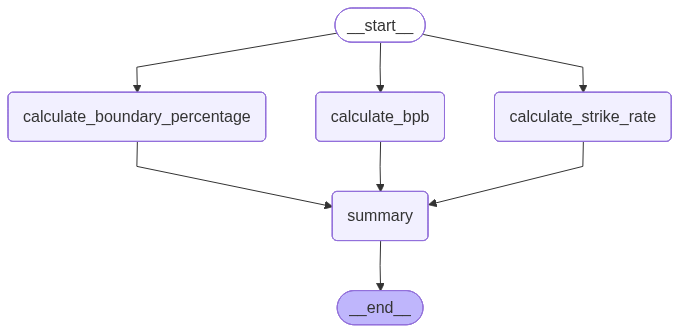

In [8]:
# (Optional) Compile the graph again if needed (already compiled above)
graph.compile()

In [9]:
# Prepare an initial state for the batsman statistics workflow
initial_state: BatsmanState = {
    "balls": 120,
    "runs": 80,
    "fours": 10,
    "sixes": 5
}
# Run the workflow and get the final state with all statistics and summary
final_state = workflow.invoke(initial_state)

In [11]:
print(final_state)

{'balls': 120, 'runs': 80, 'fours': 10, 'sixes': 5, 'sr': 66.67, 'bpb': 8.0, 'boundary_percent': 87.5, 'summary': 'Batsman Summary:\n  Strike Rate: 66.67\n  Balls per boundary: 8.00\n  Boundary Percentage: 87.50%\n'}


In [10]:
# Print the summary of the batsman's performance
print(final_state["summary"])

Batsman Summary:
  Strike Rate: 66.67
  Balls per boundary: 8.00
  Boundary Percentage: 87.50%

